In [1]:
# import statements
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup as bs
from IPython.core.display import HTML
import matplotlib.pyplot as plt
#import seaborn as sns
from io import StringIO
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from cartopy.io import shapereader
%matplotlib inline
# import io
# import scipy.stats as stats
# import statsmodels.api as sm

In [2]:
# display settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

**Create a base map for the state of TN, broken down by county.**

In [3]:
# Create a folium map, but probably not the best idea
# tn_map = folium.Map(location=[36,-86], zoom_start = 7)
# tn_map

In [4]:
# Create a base map by importing the base shape file for TN census map
# Annoyingly, this is broken down by Census division, not by county
# tn_census_map = gpd.read_file('../data/2018-TN-basemap/tl_2016_47_cousub.shp')
# tn_census_map.info()

In [5]:
# Check to see if COUNTYFP |is the right level to aggregate at to get county-level geometries
# tn_census_map['COUNTYFP'].nunique()

In [6]:
# Attempt to aggregate geometries by county
# tn_census_map.groupby('COUNTYFP')['geometry']

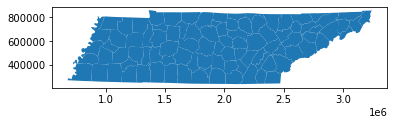

In [7]:
# Ask Michael, get this county-level base map shapefile instead
tn_county_map = gpd.read_file('../data/TN-county-basemap/tncounty.shp')
tn_county_map.plot();

In [8]:
# Take a look at the base map dataframe
tn_county_map.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ..."
2,78,Tipton,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774...."
3,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ..."
4,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ..."


In [9]:
# Check to make sure nothing is missing
tn_county_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    95 non-null     int64   
 1   NAME        95 non-null     object  
 2   KEY         95 non-null     object  
 3   SHAPE_AREA  95 non-null     float64 
 4   SHAPE_LEN   95 non-null     float64 
 5   geometry    95 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 4.6+ KB


In [29]:
# check the projection type
tn_county_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
# change the projection type
tn_county_map = tn_county_map.to_crs('EPSG:4326')
print(tn_county_map.crs)
# Make sure the base map dataset is good to go
tn_county_map.head(2)

EPSG:4326


,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((-88.78177 35.24759, -88.78185 35.247..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((-88.02474 35.39231, -88.02237 35.390..."


**Read in the deadly earthquakes since 1900 wikitable and turn it into a Geo DataFrame.**

In [12]:
earthquakes = pd.read_csv('../data/earthquakes_wikitable.csv')

In [13]:
earthquakes.head()

,origin_utc,date_ymd,time,country,lat,long,depth_km,magnitude,magnitude_num,secondary_effects,pde_shaking_deaths,pde_total_deaths,utsu_total_deaths,em_dat_total_deaths,other_source_deaths,other_source_deaths_new,osd1,osd2,osd3,max_deaths
0,1900-05-11 17:23,1900-05-11,17:23,Japan,38.700,141.100,5.0,7.0 MJMA,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,1900-07-12,06:25,Turkey,40.300,43.100,NaN,5.9 Muk,5.9,NaN,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,NaN,140.0
2,1900-10-29 09:11,1900-10-29,09:11,Venezuela,11.000,-66.000,0.0,7.7 Mw,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,1901-02-15,00:00,China,26.000,100.100,0.0,6.5 Ms,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,1901-03-31,07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,6.4,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [14]:
earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   origin_utc               1340 non-null   object 
 1   date_ymd                 1340 non-null   object 
 2   time                     1332 non-null   object 
 3   country                  1340 non-null   object 
 4   lat                      1325 non-null   object 
 5   long                     1325 non-null   object 
 6   depth_km                 1249 non-null   float64
 7   magnitude                1339 non-null   object 
 8   magnitude_num            1338 non-null   float64
 9   secondary_effects        373 non-null    object 
 10  pde_shaking_deaths       738 non-null    float64
 11  pde_total_deaths         749 non-null    float64
 12  utsu_total_deaths        1027 non-null   float64
 13  em_dat_total_deaths      559 non-null    float64
 14  other_source_deaths     

In [15]:
earthquakes['origin_utc'] = pd.to_datetime(earthquakes['origin_utc'])

In [16]:
# remove excess columns
earthquakes = earthquakes.drop(['pde_shaking_deaths', 'pde_total_deaths', 'utsu_total_deaths', 'em_dat_total_deaths', 'other_source_deaths', 'other_source_deaths_new', 'osd1', 'osd2', 'osd3'], axis = 1)

In [17]:
earthquakes.head()

,origin_utc,date_ymd,time,country,lat,long,depth_km,magnitude,magnitude_num,secondary_effects,max_deaths
0,1900-05-11 17:23:00,1900-05-11,17:23,Japan,38.700,141.100,5.0,7.0 MJMA,7.0,NaN,NaN
1,1900-07-12 06:25:00,1900-07-12,06:25,Turkey,40.300,43.100,NaN,5.9 Muk,5.9,NaN,140.0
2,1900-10-29 09:11:00,1900-10-29,09:11,Venezuela,11.000,-66.000,0.0,7.7 Mw,7.7,NaN,NaN
3,1901-02-15 00:00:00,1901-02-15,00:00,China,26.000,100.100,0.0,6.5 Ms,6.5,NaN,NaN
4,1901-03-31 07:11:00,1901-03-31,07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,6.4,NaN,4.0


In [18]:
# Clean up the lat/long columns
earthquakes['lat'] = earthquakes['lat'].str.replace('?','')
earthquakes['long'] = earthquakes['long'].str.replace('?','')

In [21]:
# Turn the lat/long into floats
earthquakes['long'] = pd.to_numeric(earthquakes['long'])
earthquakes['lat'] = pd.to_numeric(earthquakes['lat'])

In [22]:
# Create a new column named 'geometry' which combines the latitude and longitude
earthquakes['geometry'] = earthquakes.apply(lambda x: Point((float(x.long),
                                                            float(x.lat))),
                                           axis = 1)
earthquakes.head()

,origin_utc,date_ymd,time,country,lat,long,depth_km,magnitude,magnitude_num,secondary_effects,max_deaths,geometry
0,1900-05-11 17:23:00,1900-05-11,17:23,Japan,38.7,141.1,5.0,7.0 MJMA,7.0,NaN,NaN,POINT (141.1 38.7)
1,1900-07-12 06:25:00,1900-07-12,06:25,Turkey,40.3,43.1,NaN,5.9 Muk,5.9,NaN,140.0,POINT (43.1 40.3)
2,1900-10-29 09:11:00,1900-10-29,09:11,Venezuela,11.0,-66.0,0.0,7.7 Mw,7.7,NaN,NaN,POINT (-66 11)
3,1901-02-15 00:00:00,1901-02-15,00:00,China,26.0,100.1,0.0,6.5 Ms,6.5,NaN,NaN,POINT (100.1 26)
4,1901-03-31 07:11:00,1901-03-31,07:11,Bulgaria,43.4,28.7,NaN,6.4 Muk,6.4,NaN,4.0,POINT (28.7 43.4)


In [23]:
# Turn the Wikipedia Deadly Earthquakes since 1900 table into a Geo Data Frame
deadly_earthquakes_geo = gpd.GeoDataFrame(earthquakes,
                                         crs = tn_county_map.crs,
                                         geometry = earthquakes['geometry'])

The Wikipedia deadly earthquakes since 1900 table is now ready for a spatial join.

**Next, pull in the USGS data for earthquakes in TN (as defined in this gist: https://gist.github.com/jakebathman/719e8416191ba14bb6e700fc2d5fccc5) and turn it into a Geo DataFrame.**

In [24]:
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=1900-01-01&endtime=2020-10-22&minlatitude=34.9884&maxlatitude=36.6871&minlongitude=-90.3131&maxlongitude=-81.6518'

In [25]:
r = requests.get(url)

In [26]:
usgs = pd.read_csv(StringIO(r.text))
usgs.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2020-10-21T21:49:45.720Z,36.070500,-89.802333,6.84,2.14,md,46.0,40.0,0.06430,0.10,nm,nm60312762,2020-10-22T12:49:53.160Z,"2 km NNE of Cooter, Missouri",earthquake,0.17,0.49,0.092,31.0,reviewed,nm,nm
1,2020-10-21T20:28:42.930Z,36.525000,-89.569167,6.85,1.69,md,19.0,50.0,0.02596,0.03,nm,nm60312752,2020-10-22T14:45:56.660Z,"3 km E of Marston, Missouri",earthquake,0.34,0.63,0.167,12.0,reviewed,nm,nm
2,2020-10-21T04:55:51.350Z,36.545667,-89.649000,8.01,1.61,md,24.0,44.0,0.02245,0.04,nm,nm60312697,2020-10-21T13:04:57.100Z,"4 km NW of Marston, Missouri",earthquake,0.44,0.40,0.147,21.0,reviewed,nm,nm
3,2020-10-21T03:00:08.800Z,36.313667,-89.536167,9.50,1.23,md,17.0,65.0,0.02693,0.06,nm,nm60312692,2020-10-21T13:18:24.430Z,"7 km NW of Ridgely, Tennessee",earthquake,0.68,0.51,0.032,10.0,reviewed,nm,nm
4,2020-10-20T18:50:21.800Z,36.267500,-89.523333,8.84,2.33,md,46.0,33.0,0.01520,0.11,nm,nm60312672,2020-10-21T12:29:35.220Z,"3 km W of Ridgely, Tennessee",earthquake,0.15,0.30,0.142,34.0,reviewed,nm,nm


In [32]:
# Create a geometry column
usgs['geometry'] = usgs.apply(lambda x: Point((float(x.longitude),
                                            float(x.latitude))),
                              axis = 1)
usgs.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,geometry
0,2020-10-21T21:49:45.720Z,36.070500,-89.802333,6.84,2.14,md,46.0,40.0,0.06430,0.10,nm,nm60312762,2020-10-22T12:49:53.160Z,"2 km NNE of Cooter, Missouri",earthquake,0.17,0.49,0.092,31.0,reviewed,nm,nm,POINT (-89.8023333 36.0705)
1,2020-10-21T20:28:42.930Z,36.525000,-89.569167,6.85,1.69,md,19.0,50.0,0.02596,0.03,nm,nm60312752,2020-10-22T14:45:56.660Z,"3 km E of Marston, Missouri",earthquake,0.34,0.63,0.167,12.0,reviewed,nm,nm,POINT (-89.5691667 36.525)
2,2020-10-21T04:55:51.350Z,36.545667,-89.649000,8.01,1.61,md,24.0,44.0,0.02245,0.04,nm,nm60312697,2020-10-21T13:04:57.100Z,"4 km NW of Marston, Missouri",earthquake,0.44,0.40,0.147,21.0,reviewed,nm,nm,POINT (-89.649 36.5456667)
3,2020-10-21T03:00:08.800Z,36.313667,-89.536167,9.50,1.23,md,17.0,65.0,0.02693,0.06,nm,nm60312692,2020-10-21T13:18:24.430Z,"7 km NW of Ridgely, Tennessee",earthquake,0.68,0.51,0.032,10.0,reviewed,nm,nm,POINT (-89.5361667 36.3136667)
4,2020-10-20T18:50:21.800Z,36.267500,-89.523333,8.84,2.33,md,46.0,33.0,0.01520,0.11,nm,nm60312672,2020-10-21T12:29:35.220Z,"3 km W of Ridgely, Tennessee",earthquake,0.15,0.30,0.142,34.0,reviewed,nm,nm,POINT (-89.5233333 36.2675)


In [34]:
# Subset to earthquakes that have happened within TN only, based on the place name
# Not actually necessary if we're going to plot points based on lat/long
# usgs_tn = usgs[usgs['place'].str.contains('(Tennessee)')]
# usgs_tn.info()

In [35]:
# Turn the USGS dataframe into a Geo DataFrame
usgs_geo = gpd.GeoDataFrame(usgs,
                             crs = tn_county_map.crs,
                             geometry = usgs['geometry'])